# Spark Funds Investment Analysis

Following are the business objectives and goals of data analysis.

**Business objective**: The objective is to identify the best sectors, countries, and a suitable investment type for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

**Goals of data analysis**: data analysis goals are divided into three sub-goals:
* Investment type analysis: Comparing the typical investment amounts in the venture, seed, angel, private equity etc. so that Spark Funds can choose the type that is best suited for their strategy.
* Country analysis: Identifying the countries which have been the most heavily invested in the past. These will be Spark Funds’ favourites as well, the additional constraint is that Sparks Funds' wants to invest in english speaking countries only.
* Sector analysis: Understanding the distribution of investments across the eight main sectors. (Note that we are interested in the eight 'main sectors' provided in the mapping file. The two files — companies and rounds2 — have numerous sub-sector names; hence, you will need to map each sub-sector to its main sector.)

In [729]:
# load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Checkpoint 1: Data Cleaning

In [730]:
# load the companies data frame based on companies.txt file provided.
companies = pd.read_csv('./companies.txt',sep='\t', encoding = "ISO-8859-1")
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [731]:
# Analyzing the companies data frame
print(companies.shape)
companies.describe()

(66368, 10)


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Social-Grade,Roost,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [732]:
# find how many % of values in columns are null
100*(companies.isnull().sum()/len(companies.index))

permalink         0.000000
name              0.001507
homepage_url      7.621143
category_list     4.743250
status            0.000000
country_code     10.483968
state_code       12.878194
region           12.099204
city             12.096191
founded_at       22.934245
dtype: float64

We can observe from above that:
* permalink is the unique identifier with no null value and frequency of occurance as 1
* We observe from above that around 10.5% rows have country code missing, we cannot use this data as we need to find english speaking countries for investment.

The business objective of our analysis does not require columns like state_code,region, city,founded_at, let's remove these columns

In [733]:
companies = companies.iloc[:,:-4]

In [734]:
# find how many rows have all values as null
companies.isnull().all(axis=1).sum()

0

In [735]:
# number of unique companies in company.txt
companies.permalink.describe()

count                          66368
unique                         66368
top       /Organization/Social-Grade
freq                               1
Name: permalink, dtype: object

In [737]:
# load funding rounds data in data frame rounds2
rounds2 = pd.read_csv('./rounds2.csv',encoding = "ISO-8859-1")

# inspect the rounds2 data frame
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


In [738]:
# check the percentage of null values present.
100*(rounds2.isnull().sum()/len(rounds2.index))

company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.909725
funded_at                   0.000000
raised_amount_usd          17.390321
dtype: float64

We see from above that around 17.39% of data does not have any funding amount raised information.

In [739]:
# number of unique companies listed in rounds2
rounds2.company_permalink.describe()

count                       114949
unique                       90247
top       /ORGANIZATION/SOLARFLARE
freq                            10
Name: company_permalink, dtype: object

In [8]:
# what is the median raised amount
rounds2.raised_amount_usd.median()
# rounds2.raised_amount_usd.describe()

1680511.0

In [740]:
# we observe that companiy permalink in companies and rounds2 data frames have different casing
# we will convert the company permalink in both companies and rounds2 data frames to lowercase
companies.permalink = companies.permalink.apply(lambda x: str.lower(x))
rounds2.company_permalink = rounds2.company_permalink.apply(lambda x: str.lower(x))

In [834]:
# take inner join of companies and rounds2 data frames and creat a new data frame master_frame
master_frame = companies.merge(rounds2,how='inner',left_on='permalink',right_on='company_permalink')

In [835]:
# find number of observations present in master_frame
len(master_frame)

114942

In [78]:
# check the % of missing values in master_frame
100*(master_frame.isnull().sum()/len(master_frame.index))

permalink                   0.000000
name                        0.000870
homepage_url                5.334865
category_list               2.964104
status                      0.000000
country_code                7.543805
state_code                  9.516974
region                      8.839241
city                        8.836631
founded_at                 17.852482
company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.908945
funded_at                   0.000000
raised_amount_usd          17.386160
dtype: float64

We observe from above that among the important columns we have missing values:
* 7.54% of country data is missing
* 2.96% of category list investment area is missing
* 17.39% of investment amount raised is missing

Let us check the proportion of investment amount which is getting impacted due to missing country and category_list information.

In [743]:
# proportion of total funding amount for which country code is missing
100*(master_frame[master_frame.country_code.isnull()].raised_amount_usd.sum()/master_frame.raised_amount_usd.sum())

5.767927483099499

In [744]:
# proportion of total funding amount for which category list is missing
100*(master_frame[master_frame.category_list.isnull()].raised_amount_usd.sum()/master_frame.raised_amount_usd.sum())

1.1231459170813058

In [745]:
# proportion of total funding amount for which either category list or country or both is missing
100*(master_frame[master_frame.category_list.isnull()|master_frame.country_code.isnull()].raised_amount_usd.sum()/master_frame.raised_amount_usd.sum())

6.351128930081111

In [746]:
# let us check details about master_frame number of entries etc.
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114942 entries, 0 to 114941
Data columns (total 12 columns):
permalink                  114942 non-null object
name                       114941 non-null object
homepage_url               108810 non-null object
category_list              111535 non-null object
status                     114942 non-null object
country_code               106271 non-null object
company_permalink          114942 non-null object
funding_round_permalink    114942 non-null object
funding_round_type         114942 non-null object
funding_round_code         31139 non-null object
funded_at                  114942 non-null object
raised_amount_usd          94958 non-null float64
dtypes: float64(1), object(11)
memory usage: 11.4+ MB


In [747]:
# find out if there are any company entries in rounds2 that are not present in company data
# we do so by taking a left outer join b/w rounds2 and companies data frames and 
# counting the number of null permalink values present.
pd.merge(rounds2,companies,how='left', left_on='company_permalink',right_on='permalink').permalink.isnull().sum()

7

we can also find out which are these 7 company_permalink values that are present in rounds2 data frame but not present
in companies data frame.
Below we will do analysis by an alternative method to find the companies which are present in rounds2 data frame but not in companies data frame.

In [748]:
# derive list of companies that are in companies data frame
company_list = list(companies.permalink)

In [749]:
# find companies in rounds2 which are not present in list of companies
rounds2.loc[~rounds2.company_permalink.isin(company_list),:]

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
29597,/organization/e-cãbica,/funding-round/8491f74869e4fe8ba9c378394f8fbdea,seed,NaN,01-02-2015,NaN
31863,/organization/energystone-games-çµç³æ¸¸æ,/funding-round/b89553f3d2279c5683ae93f45a21cfe0,seed,NaN,09-08-2014,NaN
45176,/organization/huizuche-com-æ ç§ÿè½¦,/funding-round/8f8a32dbeeb0f831a78702f83af78a36,seed,NaN,18-09-2014,NaN
58473,/organization/magnet-tech-ç£ç³ç§æ,/funding-round/8fc91fbb32bc95e97f151dd0cb4166bf,seed,NaN,16-08-2014,1625585.0
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,/funding-round/41005928a1439cb2d706a43cb661f60f,seed,NaN,06-09-2010,NaN
109969,/organization/weiche-tech-åè½¦ç§æ,/funding-round/f74e457f838b81fa0b29649740f186d8,venture,A,06-09-2015,NaN
113839,/organization/zengame-ç¦ æ¸¸ç§æ,/funding-round/6ba28fb4f3eadf5a9c6c81bc5dde6cdf,seed,NaN,17-07-2010,NaN


In [750]:
master_frame.head()

,permalink,name,homepage_url,category_list,status,country_code,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


## Checkpoint 2: Funding Type Analysis
We need to analyze funding type most suitable for investment by Spark Fund's. Specifically we are interested in
the following four investment types: seed, angel, venture and private equity. A brief description of these investment types is as below:
* **Seed/angel** funding refer to early stage startups whereas **venture** funding occurs after seed or angel stage/s and involves a relatively higher amount of investment.
* **Private equity** type investments are associated with much larger companies and involve much higher investments than venture type. Startups which have grown in scale may also receive private equity funding. This means that if a company has reached the venture stage, it would have already passed through the angel or seed stage/s


In [836]:
# find the mean of funding amount grouped by funding_round_type
funding_round_type_mean = master_frame.groupby('funding_round_type').raised_amount_usd.mean().astype('int')

In [838]:
# sort funding values in descending order
# convert into millions ( 1 million = 1000000)
funding_round_type_mean.sort_values(ascending=False)*10**-6

funding_round_type
post_ipo_debt            168.704571
post_ipo_equity           82.182493
secondary_market          79.649630
private_equity            73.308593
undisclosed               19.242370
debt_financing            17.043526
venture                   11.748949
grant                      4.300576
convertible_note           1.453438
product_crowdfunding       1.363131
angel                      0.958694
seed                       0.719779
equity_crowdfunding        0.538368
non_equity_assistance      0.411203
Name: raised_amount_usd, dtype: float64

From the average investment across various funding types above it is clear that it is the **venture** investment type which is between 5 and 15 million which is most suitable for them.

In [839]:
# let us also check the median investment across funding types
funding_round_type_median = master_frame.groupby('funding_round_type').raised_amount_usd.median().astype('int')

In [840]:
# sort funding values in descending order
# convert into millions ( 1 million = 1000000)
funding_round_type_median.sort_values(ascending=False)*10**-6

funding_round_type
secondary_market         32.600000
private_equity           20.000000
post_ipo_debt            19.950000
post_ipo_equity          12.262852
venture                   5.000000
debt_financing            1.100000
undisclosed               1.018680
angel                     0.400000
seed                      0.275000
convertible_note          0.272000
grant                     0.201684
product_crowdfunding      0.183915
equity_crowdfunding       0.100000
non_equity_assistance     0.060000
Name: raised_amount_usd, dtype: float64

from median view also it's clear that across four funding types seed, angel, venture and private equity - **venture** is most suitable for investment by Spark Funds' considering investment bucket of between 5 to 15 million.

## Checkpoint 3: Country Analysis
let us check the top 9 countries where investments are happening for funding type - venture

In [755]:
# extract top 9 countries based on funding type 'venture'
top9 = master_frame.loc[master_frame.funding_round_type=='venture',:].groupby('country_code')

In [756]:
# find the sum of investments happening for each country
top9 = top9.raised_amount_usd.sum()

In [757]:
# sort the countries based on investment amount (descending)
top9 = top9.sort_values(ascending=False)*10**-6

In [758]:
# extract the top 9 investment destinations
top9 = top9.iloc[:9]

In [759]:
# check the top 9 country based on total investment for funding type 'venture'
top9

country_code
USA    422510.842796
CHN     39835.418773
GBR     20245.627416
IND     14391.858718
CAN      9583.332317
FRA      7259.536732
ISR      6907.514579
DEU      6346.959822
JPN      3363.676611
Name: raised_amount_usd, dtype: float64

In [760]:
# let us create an new column name 'country' to hold country name
master_frame['country']= np.NAN

In [761]:
# let us set the country names for top 9 countries
master_frame.loc[master_frame.country_code=='USA','country']='United States'
master_frame.loc[master_frame.country_code=='GBR','country']='United Kingdom'
master_frame.loc[master_frame.country_code=='CHN','country']='China'
master_frame.loc[master_frame.country_code=='IND','country']='India'
master_frame.loc[master_frame.country_code=='CAN','country']='Canada'
master_frame.loc[master_frame.country_code=='FRA','country']='France'
master_frame.loc[master_frame.country_code=='ISR','country']='Israel'
master_frame.loc[master_frame.country_code=='DEU','country']='Denmark'
master_frame.loc[master_frame.country_code=='JPN','country']='Japan'

Inspecting the Countries_where_English_is_an_official_language.pdf provided we can see that out of the top 9 investment destination countries **United States**,**United Kingdom** and **India** are the top 3 countries where english is official language.

In [762]:
# let us access the impact the missing investment amount, by assuming we replace missing values by median investment value
missing = len(master_frame.loc[master_frame.raised_amount_usd.isnull(),'raised_amount_usd'])*(master_frame.raised_amount_usd.median())

In [763]:
100*(missing/(missing+master_frame.raised_amount_usd.sum()))

3.2805804739277744

we can see that only about 3.3% of investment amount seems to be impacted because of missing investment values. we decide to remove rowss where investment amount is missing.

In [764]:
# remove all those rows where funded amount information is not available
master_frame = master_frame.loc[~master_frame.raised_amount_usd.isnull()]

In [765]:
# let us also remove the rows where country is missing or where category list is missing. 
master_frame = master_frame[~(master_frame.category_list.isnull()|master_frame.country_code.isnull())]

In [766]:
master_frame.head()

,permalink,name,homepage_url,category_list,status,country_code,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,country
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,India
2,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0,United States
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,China
6,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,operating,HKG,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,01-07-2014,41250.0,NaN
7,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,operating,CAN,/organization/0ndine-biomedical-inc,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,NaN,11-09-2009,43360.0,Canada


## Checkpoint 4: Sector Analysis 1
In this section we will map the numerous category list to one of the eight sectors listed in mapping.csv provided.

In [767]:
# load category list and sector mapping
mapping = pd.read_csv('./SourceData/mapping.csv')

In [768]:
# let's check if there are any missing values in mapping data frame
100*(mapping.isnull().sum()/len(mapping.index))

category_list                              0.145349
Automotive & Sports                        0.000000
Blanks                                     0.000000
Cleantech / Semiconductors                 0.000000
Entertainment                              0.000000
Health                                     0.000000
Manufacturing                              0.000000
News, Search and Messaging                 0.000000
Others                                     0.000000
Social, Finance, Analytics, Advertising    0.000000
dtype: float64

In [769]:
# inspect the mapping data
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


We see that the data frame is in wide format for better analysis let us convert to long format and create a new data frame named **sector**

In [770]:
# we see that mapping is in wide format, let us convert to long format
sector = pd.melt(mapping,id_vars =['category_list'],value_vars=['Automotive & Sports','Blanks','Cleantech / Semiconductors','Entertainment','Health','Manufacturing','News, Search and Messaging',
                                                                   'Others','Social, Finance, Analytics, Advertising']).copy()

In [771]:
# remove all those rows where main_sector is not applicable (value=0)
sector = sector[sector.value==1]

In [772]:
# let us inspect sector dataframe
sector

,category_list,variable,value
8,Adventure Travel,Automotive & Sports,1
14,Aerospace,Automotive & Sports,1
45,Auto,Automotive & Sports,1
46,Automated Kiosk,Automotive & Sports,1
47,Automotive,Automotive & Sports,1
57,Bicycles,Automotive & Sports,1
69,Boating Industry,Automotive & Sports,1
87,CAD,Automotive & Sports,1
93,Cars,Automotive & Sports,1
188,Design,Automotive & Sports,1


We notice from above that there are lot of categorie where there is a '0' in place of legitimate characters, let us find all such categories below

In [773]:
sector.loc[sector.category_list.notnull & sector.category_list.str.contains('0')]

,category_list,variable,value
1616,Energy Ma0gement,Cleantech / Semiconductors,1
1847,0notechnology,Cleantech / Semiconductors,1
1848,0tural Language Processing,Cleantech / Semiconductors,1
1849,0tural Resources,Cleantech / Semiconductors,1
2048,Waste Ma0gement,Cleantech / Semiconductors,1
2262,Digital Rights Ma0gement,Entertainment,1
2263,Digital Sig0ge,Entertainment,1
2287,Educatio0l Games,Entertainment,1
2320,Event Ma0gement,Entertainment,1
2772,Alter0tive Medicine,Health,1


We observe that in all above cases characters 'na' has been replaced by '0', let is correct all such cases.

In [774]:
sector.loc[sector.category_list.notnull & sector.category_list.str.contains('0'),'category_list']=sector.loc[sector.category_list.notnull & sector.category_list.str.contains('0'),'category_list'].str.replace('0','na')

In [775]:
# check that all such values have been replaced
len(sector.loc[sector.category_list.notnull & sector.category_list.str.contains('0')])

0

In [776]:
# rename variable as main_sector
sector.rename(columns={'variable':'main_sector'},inplace=True)
sector.head()

,category_list,main_sector,value
8,Adventure Travel,Automotive & Sports,1
14,Aerospace,Automotive & Sports,1
45,Auto,Automotive & Sports,1
46,Automated Kiosk,Automotive & Sports,1
47,Automotive,Automotive & Sports,1


In [777]:
len(sector)

688

We observe that in master_frame data frame there are several category_list values which contain multiple pipe delimited values, we apply a **business rule** in such cases to only the first category before delimiter as the primary sector.

In [778]:
# define function to extract primary sector
def findPrimaryCategory(x):
    if pd.isnull(x):
        return x
    else:
        return x.split('|')[0]

# apply above function to master_frame    
master_frame.category_list = master_frame.category_list.apply(findPrimaryCategory)

In [779]:
# let us inspect master frame after extracting primary sector
master_frame.head()

,permalink,name,homepage_url,category_list,status,country_code,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,country
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,India
2,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms,operating,USA,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0,United States
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,China
6,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,operating,HKG,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,01-07-2014,41250.0,NaN
7,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,operating,CAN,/organization/0ndine-biomedical-inc,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,NaN,11-09-2009,43360.0,Canada


In [780]:
# let us now merge sector information in master frame
master_frame = pd.merge(master_frame,sector,how='inner',left_on='category_list',right_on='category_list')

In [781]:
# rename category list column as primary sector
master_frame.rename(columns={'category_list':'primary_sector'},inplace=True)

In [782]:
len(master_frame)

88200

In [783]:
master_frame.head()

,permalink,name,homepage_url,primary_sector,status,country_code,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,country,main_sector,value
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,India,Entertainment,1
1,/organization/90min,90min,http://www.90min.com,Media,operating,GBR,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.0,United Kingdom,Entertainment,1
2,/organization/90min,90min,http://www.90min.com,Media,operating,GBR,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.0,United Kingdom,Entertainment,1
3,/organization/90min,90min,http://www.90min.com,Media,operating,GBR,/organization/90min,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,NaN,26-03-2014,18000000.0,United Kingdom,Entertainment,1
4,/organization/a-dance-for-me,A Dance for Me,http://www.adanceforme.com/,Media,operating,USA,/organization/a-dance-for-me,/funding-round/9ab9dbd17bf010c79d8415b2c22be6fa,equity_crowdfunding,NaN,26-03-2014,1090000.0,United States,Entertainment,1


In [784]:
# check if thereare any Blanks
len(master_frame.loc[master_frame.primary_sector=='Blanks'])

0

## Checkpoint 5: Sector Analysis 2
In this section we create 3 data frames D1, D2 and D3 based on top 3 english speaking investment destinations ie. United States, United Kingdom and India for funding type 'venture'

In [785]:
# Data frame D1 for top 1 country: United States, Funding Type as 'venture'
# and investment b/w 5 and 15 million usd.
D1 = master_frame[(master_frame.country_code == 'USA')&(master_frame.raised_amount_usd >= 5*10**6)
                  &(master_frame.raised_amount_usd <= 15*10**6)&(master_frame.funding_round_type=='venture')].copy()

In [786]:
D1.head()

,permalink,name,homepage_url,primary_sector,status,country_code,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,country,main_sector,value
7,/organization/all-def-digital,All Def Digital,http://alldefdigital.com,Media,operating,USA,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,A,06-08-2014,5000000.0,United States,Entertainment,1
31,/organization/chefs-feed,ChefsFeed,http://www.chefsfeed.com,Media,operating,USA,/organization/chefs-feed,/funding-round/adca195749ae9ace84684723fbe75e5b,venture,A,26-02-2015,5000000.0,United States,Entertainment,1
61,/organization/huffingtonpost,The Huffington Post,http://www.huffingtonpost.com,Media,acquired,USA,/organization/huffingtonpost,/funding-round/7f05940c4d2dfecb8e50a0e5720e5065,venture,A,01-08-2006,5000000.0,United States,Entertainment,1
62,/organization/huffingtonpost,The Huffington Post,http://www.huffingtonpost.com,Media,acquired,USA,/organization/huffingtonpost,/funding-round/9241ae16e08df17ebdc064e49e23035a,venture,B,01-09-2007,5000000.0,United States,Entertainment,1
85,/organization/matchmine,MatchMine,http://matchmine.com,Media,closed,USA,/organization/matchmine,/funding-round/41ac526630da57ad6eb9d02431b17657,venture,A,01-09-2007,10000000.0,United States,Entertainment,1


In [787]:
# let us check the top sectors based on total amount invested in millions usd
D1.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False)*10**-6

main_sector
Others                                     26321.007002
Social, Finance, Analytics, Advertising    23807.376964
Cleantech / Semiconductors                 21206.628192
News, Search and Messaging                 13959.567428
Health                                      8211.859357
Manufacturing                               7258.553378
Entertainment                               5099.197982
Automotive & Sports                         1454.104361
Name: raised_amount_usd, dtype: float64

In [788]:
# let us create a new column 'total_amt_invested' and initialize with 1
D1['total_amt_invested']=1

In [789]:
# set the total amount invested values based on sector
D1.loc[D1.main_sector=='Others','total_amt_invested'] = 26321.007002
D1.loc[D1.main_sector=='Social, Finance, Analytics, Advertising','total_amt_invested'] = 23807.376964
D1.loc[D1.main_sector=='Cleantech / Semiconductors','total_amt_invested'] = 21206.628192 
D1.loc[D1.main_sector=='News, Search and Messaging','total_amt_invested'] = 13959.567428
D1.loc[D1.main_sector=='Health','total_amt_invested'] = 8211.859357
D1.loc[D1.main_sector=='Manufacturing','total_amt_invested'] = 7258.553378
D1.loc[D1.main_sector=='Entertainment','total_amt_invested'] = 5099.197982
D1.loc[D1.main_sector=='Automotive & Sports','total_amt_invested'] = 1454.104361

In [790]:
# check the number of investments in D1 across main sector
D1.loc[:,['main_sector','value']].groupby('main_sector').count().sort_values('value',ascending=False)

,value
main_sector,
Others,2950
"Social, Finance, Analytics, Advertising",2714
Cleantech / Semiconductors,2300
"News, Search and Messaging",1582
Health,909
Manufacturing,799
Entertainment,591
Automotive & Sports,167


In [791]:
# let us create a new column 'main_sector_inv_count' for total number of investments in each sector and
# initialize by 1
D1['main_sector_inv_count']=1

In [792]:
# let us set the number of investment for each sector
D1.loc[D1.main_sector=='Others','main_sector_inv_count'] = 2950
D1.loc[D1.main_sector=='Social, Finance, Analytics, Advertising','main_sector_inv_count'] =  2714
D1.loc[D1.main_sector=='Cleantech / Semiconductors','main_sector_inv_count'] = 2300
D1.loc[D1.main_sector=='News, Search and Messaging','main_sector_inv_count'] = 1582
D1.loc[D1.main_sector=='Health','main_sector_inv_count'] = 909
D1.loc[D1.main_sector=='Manufacturing','main_sector_inv_count'] = 799
D1.loc[D1.main_sector=='Entertainment','main_sector_inv_count'] = 591
D1.loc[D1.main_sector=='Automotive & Sports','main_sector_inv_count'] = 167

In [796]:
# let us check top 3 companies recieved maximum investment for sector 'others'
D1[D1.main_sector=='Others'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
Virtustream          64300000.0
Capella Photonics    54968051.0
AirTight Networks    54201907.0
Name: raised_amount_usd, dtype: float64

In [797]:
# let us check top 3 companies for the second best sector Cleantech / Semiconductors
D1[D1.main_sector=='Social, Finance, Analytics, Advertising'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
SST Inc. (Formerly ShotSpotter)    67933006.0
Demandbase                         63000000.0
Intacct                            61800000.0
Name: raised_amount_usd, dtype: float64

In [798]:
# Data frame D2 for top 2 country: United Kingdom, Funding Type as 'venture'
# and investment b/w 5 and 15 million usd.
D2 = master_frame[(master_frame.country_code == 'GBR')&(master_frame.raised_amount_usd >= 5*10**6)
                  &(master_frame.raised_amount_usd <= 15*10**6)&(master_frame.funding_round_type=='venture')].copy()

In [799]:
# let us check the top sectors based on total amount invested in millions usd
D2.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False)*10**-6

main_sector
Others                                     1283.624289
Cleantech / Semiconductors                 1150.139665
Social, Finance, Analytics, Advertising    1089.404014
News, Search and Messaging                  615.746235
Entertainment                               482.784687
Manufacturing                               361.940335
Health                                      214.537510
Automotive & Sports                         167.051565
Name: raised_amount_usd, dtype: float64

In [800]:
# let us create a new column 'total_amt_invested' for total amount of investments in each sector and
# initialize by 1
D2['total_amt_invested']=1

In [801]:
# set the total amount invested values based on sector
D2.loc[D2.main_sector=='Others','total_amt_invested'] = 1283.624289
D2.loc[D2.main_sector=='Cleantech / Semiconductors','total_amt_invested'] = 1150.139665
D2.loc[D2.main_sector=='Social, Finance, Analytics, Advertising','total_amt_invested'] = 1089.404014
D2.loc[D2.main_sector=='News, Search and Messaging','total_amt_invested'] = 615.746235
D2.loc[D2.main_sector=='Manufacturing','total_amt_invested'] = 482.784687
D2.loc[D2.main_sector=='Entertainment','total_amt_invested'] = 361.940335
D2.loc[D2.main_sector=='Health','total_amt_invested'] = 214.537510
D2.loc[D2.main_sector=='Automotive & Sports','total_amt_invested'] = 167.051565

In [802]:
# count of number of investments in each sector in descending order for United Kingdom
D2.loc[:,['main_sector','value']].groupby('main_sector').count().sort_values('value',ascending=False)

,value
main_sector,
Others,147
"Social, Finance, Analytics, Advertising",133
Cleantech / Semiconductors,128
"News, Search and Messaging",73
Entertainment,56
Manufacturing,42
Health,24
Automotive & Sports,16


In [803]:
# let us create a new column 'main_sector_inv_count' for total number of investments in each sector and
# initialize by 1
D2['main_sector_inv_count']=1

In [804]:
# set the total number of investement values based on sector
D2.loc[D2.main_sector=='Others','main_sector_inv_count'] = 147
D2.loc[D2.main_sector=='Social, Finance, Analytics, Advertising','main_sector_inv_count'] = 133
D2.loc[D2.main_sector=='Cleantech / Semiconductors','main_sector_inv_count'] = 128
D2.loc[D2.main_sector=='News, Search and Messaging','main_sector_inv_count'] = 73
D2.loc[D2.main_sector=='Entertainment','main_sector_inv_count'] = 56
D2.loc[D2.main_sector=='Manufacturing','main_sector_inv_count'] = 42
D2.loc[D2.main_sector=='Health','main_sector_inv_count'] = 24
D2.loc[D2.main_sector=='Automotive & Sports','main_sector_inv_count'] = 16

In [805]:
# let us check which company recieved maximum investment for sector 'Others'
D2[D2.main_sector=='Others'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
Electric Cloud    37000000.0
SenSage           36250000.0
Enigmatec         32500000.0
Name: raised_amount_usd, dtype: float64

In [806]:
# let us check the second best sector investment
D2[D2.main_sector=='Social, Finance, Analytics, Advertising'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
Celltick Technologies    37500000.0
myThings                 34000000.0
Zopa                     32900000.0
Name: raised_amount_usd, dtype: float64

In [807]:
# Data frame D3 for top 3 country: India, Funding Type as 'venture'
# and investment b/w 5 and 15 million usd.
D3 = master_frame[(master_frame.country_code == 'IND')&(master_frame.raised_amount_usd >= 5*10**6)
                  &(master_frame.raised_amount_usd <= 15*10**6)&(master_frame.funding_round_type=='venture')].copy()

In [808]:
# let us check the top sectors based on total amount invested in millions usd
D3.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False)*10**-6

main_sector
Others                                     1013.409507
Social, Finance, Analytics, Advertising     550.549550
News, Search and Messaging                  433.834545
Entertainment                               280.830000
Manufacturing                               200.900000
Health                                      167.740000
Cleantech / Semiconductors                  165.380000
Automotive & Sports                         136.900000
Name: raised_amount_usd, dtype: float64

In [809]:
# let us create a new column 'total_amt_invested' for total amount of investments in each sector and
# initialize by 1
D3['total_amt_invested']=1

In [810]:
# set the total amount invested values based on sector
D3.loc[D3.main_sector=='Others','total_amt_invested'] = 1013.409507
D3.loc[D3.main_sector=='Social, Finance, Analytics, Advertising','total_amt_invested'] = 550.549550
D3.loc[D3.main_sector=='News, Search and Messaging','total_amt_invested'] = 433.834545
D3.loc[D3.main_sector=='Entertainment','total_amt_invested'] = 280.830000
D3.loc[D3.main_sector=='Manufacturing','total_amt_invested'] = 200.900000
D3.loc[D3.main_sector=='Health','total_amt_invested'] = 167.740000
D3.loc[D3.main_sector=='Cleantech / Semiconductors','total_amt_invested'] = 165.380000
D3.loc[D3.main_sector=='Automotive & Sports','total_amt_invested'] = 136.900000

In [579]:
# count of investment in each sector in descending order for India
D3.loc[:,['main_sector','value']].groupby('main_sector').count().sort_values('value',ascending=False)

,value
main_sector,
Others,110
"Social, Finance, Analytics, Advertising",60
"News, Search and Messaging",52
Entertainment,33
Manufacturing,21
Cleantech / Semiconductors,20
Health,19
Automotive & Sports,13


In [811]:
# let us create a new column 'main_sector_inv_count' for total number of investments in each sector
# and initialize by 1.
D3['main_sector_inv_count']=1

In [812]:
# let us set the total number of investment for each sector.
D3.loc[D3.main_sector=='Others','main_sector_inv_count'] = 110
D3.loc[D3.main_sector=='Social, Finance, Analytics, Advertising','main_sector_inv_count'] = 60
D3.loc[D3.main_sector=='News, Search and Messaging','main_sector_inv_count'] = 52
D3.loc[D3.main_sector=='Entertainment','main_sector_inv_count'] = 33
D3.loc[D3.main_sector=='Manufacturing','main_sector_inv_count'] = 21
D3.loc[D3.main_sector=='Cleantech / Semiconductors','main_sector_inv_count'] = 20
D3.loc[D3.main_sector=='Health','main_sector_inv_count'] = 19
D3.loc[D3.main_sector=='Automotive & Sports','main_sector_inv_count'] = 13

In [813]:
# let us check which top 3 companies which recieved maximum investment for sector 'Others'
D3[D3.main_sector=='Others'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
FirstCry.com    39000000.0
Myntra          38000000.0
CommonFloor     32900000.0
Name: raised_amount_usd, dtype: float64

In [814]:
# let us check top 3 countries investment in second best sector
D3[D3.main_sector=='Social, Finance, Analytics, Advertising'].groupby('name').raised_amount_usd.sum().sort_values(ascending=False)[0:3]

name
Manthan Systems    50700000.0
Komli Media        28000000.0
ShopClues.com      25000000.0
Name: raised_amount_usd, dtype: float64

In [815]:
# Total number of investment count - USA
D1.loc[:,['main_sector','value']].groupby('main_sector').count().sum()

value    12012
dtype: int64

In [816]:
# Total number of investment count - United Kingdom
D2.loc[:,['main_sector','value']].groupby('main_sector').count().sum()

value    619
dtype: int64

In [817]:
# Total number of investment count - India
D3.loc[:,['main_sector','value']].groupby('main_sector').count().sum()

value    328
dtype: int64

In [818]:
# Total amount of investment in USA 
D1.raised_amount_usd.sum()

107318294664.0

In [819]:
# Total amount of investment in United Kingdom 
D2.raised_amount_usd.sum()

5365228300.0

In [821]:
# Total amount of investment in India 
D3.raised_amount_usd.sum()

2949543602.0

## Checkpoint 6: Plots

In this section we draw various visualizations to represent what should be the best investment option for Spark funds

In [822]:
# as we need to visualize total investment globally in venture, seed and private_equity, let's filter
# the data from master_frame in new data frame c1
c1 = master_frame[(master_frame.funding_round_type=='venture') | (master_frame.funding_round_type=='seed')|
                  (master_frame.funding_round_type=='private_equity')].copy()

Plot for fraction of total investments globally in venture, seed and private equity
& average amount of funding in each.

In [823]:
# will create a categorical variable to indicate if average investment amount is within range or not.
c1['Is_within_investment_range']= False
c1.loc[c1.funding_round_type=='venture','Is_within_investment_range']=True

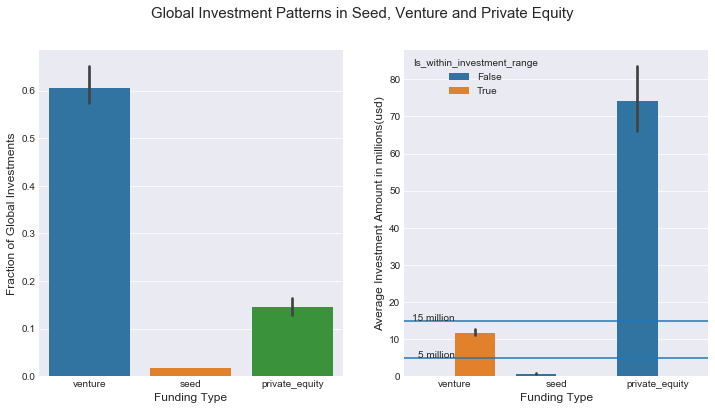

In [825]:
# increase figure size 
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# create title for all plots
plt.suptitle('Global Investment Patterns in Seed, Venture and Private Equity',fontsize =15)

# create subplot 1 containing fraction of total investments
plt.subplot(1, 2, 1)
sns.barplot(x=c1.funding_round_type,y=(c1.raised_amount_usd/master_frame.raised_amount_usd.sum()),estimator=np.sum)
plt.ylabel('Fraction of Global Investments',fontsize =12)
plt.xlabel('Funding Type',fontsize =12)

# create subplot 2 containing average investments
ax =plt.subplot(1, 2, 2)
sns.barplot(x=c1.funding_round_type,y=(c1.raised_amount_usd)*10**-6,hue=c1.Is_within_investment_range)
plt.ylabel('Average Investment Amount in millions(usd)',fontsize =12)
plt.xlabel('Funding Type',fontsize =12)
# add horizontal line at 5 million mark
ax.axhline(y=5)
# add horizontal line at 15 million mark
ax.axhline(y=15)
# add label for 5 million mark
ax.text(0,5,'5 million',ha='right')
# add label for 15 million mark
ax.text(0,15,'15 million',ha='right')

plt.show()

From above plots it is clear that funding type venture accounts for 60% of number of investments globally while the average investment amount is with 5 to 15 million usd as required by Spark Funds' strategy.

In [826]:
# let's create a new data frame copy for venture funding type which contain top 9 investment countries
c2 = master_frame.loc[(master_frame.funding_round_type=='venture') & (master_frame.country_code.isin(top9.index))].copy()

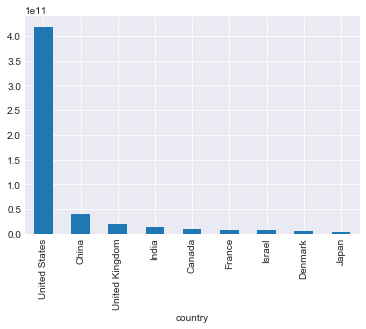

In [827]:
# below is one way to create top 9 investment countries for venture fund
c2.groupby('country').raised_amount_usd.sum().sort_values(ascending=False).plot(kind='bar')
plt.show()

In [828]:
# another way is by using seaborn, create a groupby object based on country
c2_grouped = c2.groupby('country').raised_amount_usd.sum().sort_values(ascending=False)

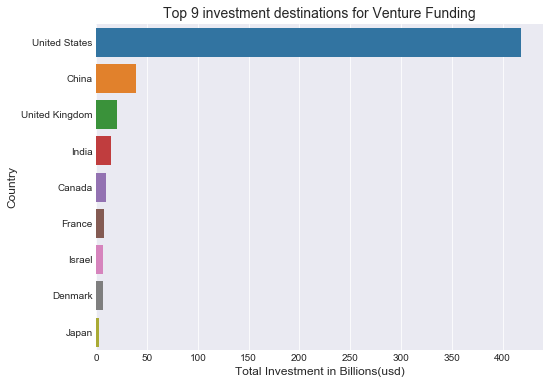

In [829]:
# draw a plot to diplay top 9 investment destinations
plt.figure(figsize=(8, 6))
plt.title('Top 9 investment destinations for Venture Funding',fontsize=14)
sns.barplot(y=c2_grouped.index,x=(c2_grouped.values)*10**-9,estimator=np.sum)
plt.xlabel('Total Investment in Billions(usd)',fontsize=12)
plt.ylabel('Country',fontsize=12)
plt.show()

Based on the top 9 investment destinations shown above the top 3 investment destination where english is official language are: United States, United Kingdom and India

In [830]:
# let's now filter out top 3 countries in new data frame c3
c3 = c2[c2.country_code.isin(['USA','CHN','GBR'])& c2.main_sector.isin(['Others','Cleantech / Semiconductors','Social, Finance, Analytics, Advertising'])]

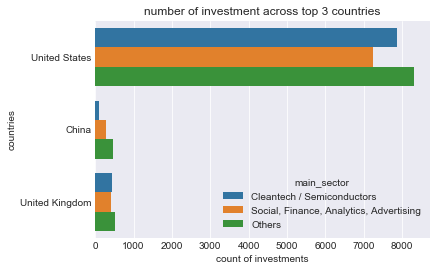

In [831]:
sns.countplot(y= c3.country,hue=c3.main_sector)
plt.title('number of investment across top 3 countries')
plt.ylabel('countries')
plt.xlabel('count of investments')
plt.show()

Let us also draw top investment sectors for top 3 English speaking countries.

In [832]:
# create a new data frame using concatenation of top 3 sectors of the top 3 countries (english speaking)
top3 = pd.concat([D1.loc[D1.main_sector.isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]
                 ,D2.loc[D2.main_sector.isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]                          
                  ,D3.loc[D3.main_sector.isin(['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging'])]
                 ], axis=0 )

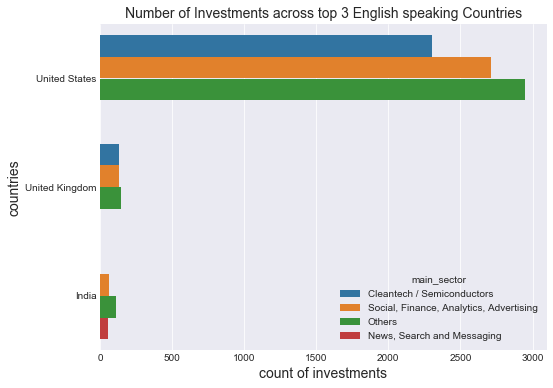

In [833]:
# let us draw plot for the same.

# increase figure size 
plt.figure(figsize=(8, 6))
sns.countplot(y= top3.country,hue=top3.main_sector)
plt.title('Number of Investments across top 3 English speaking Countries',fontsize=14)
plt.ylabel('countries',fontsize=14)
plt.xlabel('count of investments',fontsize=14)
plt.show()

Following are the analysis findings:

The most appropriate funding round for invest by Spark Funds is venture. The reason for this is as follows:
* Venture funding constitutes about 60% of global investments based on number of investments
* The average venture funding is between 5-15 million us dollars investment amount range that Spark Funds wants to invest               

The top 3 countries to target for investment by Spark Funds are: United States, United Kingdom and India. These are:
* Among the top 9 most invested countries in the world.
* Are all countries where English is official language.

The top sectors to invest in above countries are:
* Others
* Social, Finance, Analytics, Advertising
* Cleantech / Semiconductors
* News, Search and Messaging       
